# Створення нейронної мережі

У цьому завданні ми створимо повнозв'язну нейронну мережу, використовуючи при цьому низькорівневі механізми tensorflow.

Архітектура нейромережі представлена на наступному малюнку. Як бачиш, у ній є один вхідний шар, два приховані, а також вихідний шар. В якості активаційної функції у прихованих шарах буде використовуватись сигмоїда. На вихідному шарі ми використовуємо softmax.

Частина коду зі створення мережі вже написана, тобі потрібно заповнити пропуски у вказаних місцях.

## Архітектура нейронної мережі

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## Про датасет MNIST

Дану нейромережу ми будемо вивчати на датасеті MNIST. Цей датасет являє собою велику кількість зображень рукописних цифр розміром $28 \times 28$ пікселів. Кожен піксель приймає значення від 0 до 255.

Як і раніше, датасет буде розділений на навчальну та тестову вибірки. При цьому ми виконаємо нормалізацію всіх зображень, щоб значення пікселів знаходилось у проміжку від 0 до 1, розділивши яскравість кожного пікселя на 255.

Окрім того, архітектура нейронної мережі очікує на вхід вектор. У нашому ж випадку кожен об'єкт вибірки являє собою матрицю. Що ж робити? У цьому завданні ми "розтягнемо" матрицю $28 \times 28$, отримавши при цьому вектор, що складається з 784 елементів.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Більше інформації про датасет можна знайти [тут](http://yann.lecun.com/exdb/mnist/).

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import keras as K
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [2]:
num_classes = 10 # загальна кількість класів, у нашому випадку це цифри від 0 до 9
num_features = 784 # кількість атрибутів вхідного вектора 28 * 28 = 784

learning_rate = 0.001 # швидкість навчання нейронної мережі
training_steps = 5000 # максимальне число епох
batch_size = 512 # перераховувати ваги мережі ми будемо не на всій вибірці, а на її випадковій підмножині з batch_size елементів
display_step = 100 # кожні 100 ітерацій ми будемо показувати поточне значення функції втрат і точності

n_hidden_1 = 256 # кількість нейронів 1-го шару
n_hidden_2 = 512 # кількість нейронів 2-го шару

In [3]:
# from tensorflow.keras.datasets import mnist
from keras.datasets import mnist

# Завантажуємо датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Перетворюємо цілочисельні пікселі на тип float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Перетворюємо матриці розміром 28x28 пікселів у вектор з 784 елементів
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормалізуємо значення пікселів
x_train, x_test = x_train / 255., x_test / 255.

# Перемішаємо тренувальні дані
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

11490434/11490434 [==============================] - 0s 0us/step


In [4]:
# Створимо нейронну мережу

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name="w"
        )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x, activation=0):
        y = tf.matmul(x, self.w) + self.b
        if activation != 0:
            return tf.nn.softmax(y)
        else:
            return tf.nn.sigmoid(y)

class NN(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    # Перший шар, який складається з 256 нейронів
    # Місце для вашого коду
    self.layer1 = DenseLayer(num_features, n_hidden_1, name="layer1")
    # Другий шар, який складається з 512 нейронів
    # Місце для вашого коду
    self.layer2 = DenseLayer(n_hidden_1, n_hidden_2, name="layer2")
    # Вихідний шар
    # Місце для вашого коду
    self.out_layer = DenseLayer(n_hidden_2, num_classes, name="out_layer")



  def __call__(self, x):
    # Передача даних через перші два шари та вихідний шар з функцією активації softmax
    # Місце для вашого коду
    x = tf.nn.relu(self.layer1(x, activation=1))
    x = tf.nn.relu(self.layer2(x, activation=1))
    x = self.out_layer(x, activation=1)


    return x # Місце для вашого коду

In [5]:
# В якості функції помилки в даному випадку зручно взяти крос-ентропію
def cross_entropy(y_pred, y_true):
    # Закодувати label в one hot vector
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Значення передбачення, щоб уникнути помилки log(0).
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Обчислення крос-ентропії
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# Як метрику якості використовуємо точність
def accuracy(y_pred, y_true):
  # Місце для вашого коду
    # Порівнюємо індекси максимальних значень передбачень із індексами правильних міток
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    # Перетворюємо булеві значення на числовий тип та обчислюємо середню точність
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32), axis=-1)

In [6]:
# Створимо екземпляр нейронної мережі
neural_net = NN(name="mnist")

# Функція навчання нейромережі
def train(neural_net, input_x, output_y):
  # Для налаштування вагів мережі будемо використовувати стохастичний градієнтний спуск
  optimizer = tf.optimizers.Adam(learning_rate)

  # Активація автоматичного диференціювання
  with tf.GradientTape() as g:
    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)

    # Отримаємо список оптимізованих параметрів
    # Місце для вашого коду
    trainable_variables = neural_net.trainable_variables
    # Обчислимо за ними значення градієнта
    # Місце для вашого коду
    gradients = g.gradient(loss, trainable_variables)

    # Модифікуємо параметри
    # Місце для вашого коду
    optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss

In [7]:
# Тренування мережі

loss_history = []  # кожні display_step кроків зберігай в цьому списку поточну помилку нейромережі
accuracy_history = [] # кожні display_step кроків зберігай в цьому списку поточну точність нейромережі

# У цьому циклі ми будемо проводити навчання нейронної мережі
# із тренувального датасета train_data вилучи випадкову підмножину, на якій
# відбудеться тренування. Використовуй метод take, доступний для тренувального датасета.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Оновлюємо ваги нейронної мережі
    # Місце для вашого коду
    loss = train(neural_net, batch_x, batch_y)

    if step % display_step == 0:
        pred = neural_net(batch_x)
        # Місце для вашого коду
        acc = accuracy(pred, batch_y)
        loss_history.append(loss)
        accuracy_history.append(acc)
        print(f"Крок: {step}, Поточна втрата: {loss}, Точність: {acc}")


Крок: 100, Поточна втрата: 1144.73974609375, Точність: 0.384765625
Крок: 200, Поточна втрата: 1090.4051513671875, Точність: 0.5390625
Крок: 300, Поточна втрата: 1037.3897705078125, Точність: 0.630859375
Крок: 400, Поточна втрата: 965.6685180664062, Точність: 0.68359375
Крок: 500, Поточна втрата: 892.624755859375, Точність: 0.744140625
Крок: 600, Поточна втрата: 822.7494506835938, Точність: 0.740234375
Крок: 700, Поточна втрата: 736.697021484375, Точність: 0.775390625
Крок: 800, Поточна втрата: 680.541748046875, Точність: 0.7734375
Крок: 900, Поточна втрата: 599.8382568359375, Точність: 0.806640625
Крок: 1000, Поточна втрата: 540.138427734375, Точність: 0.78515625
Крок: 1100, Поточна втрата: 497.66424560546875, Точність: 0.779296875
Крок: 1200, Поточна втрата: 453.9411926269531, Точність: 0.80078125
Крок: 1300, Поточна втрата: 403.89007568359375, Точність: 0.833984375
Крок: 1400, Поточна втрата: 358.02825927734375, Точність: 0.828125
Крок: 1500, Поточна втрата: 373.2946472167969, Точніс

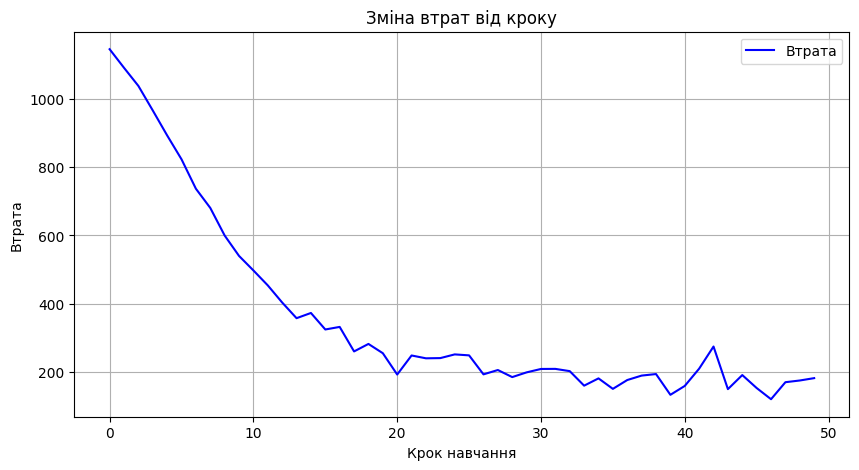

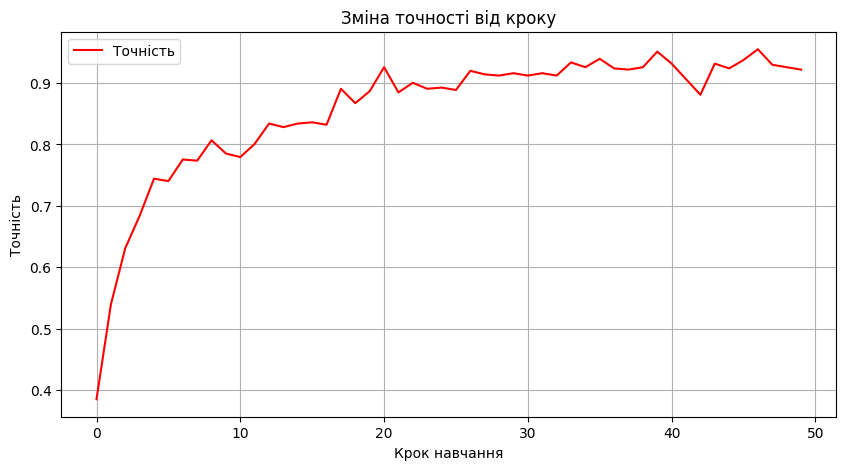

In [8]:
# Виведіть графіки залежності зміни точності і втрат від кроку
# Якщо все зроблено правильно, то точність повинна зростати, а втрати зменшуватись

import matplotlib.pyplot as plt

# Виведіть графік функції втрат
# Місце для вашого коду
plt.figure(figsize=(10, 5))
plt.plot(loss_history, label='Втрата', color='blue')
plt.title('Зміна втрат від кроку')
plt.xlabel('Крок навчання')
plt.ylabel('Втрата')
plt.legend()
plt.grid(True)
plt.show()

# Виведіть графік точності
# Місце для вашого коду
plt.figure(figsize=(10, 5))
plt.plot(accuracy_history, label='Точність', color='red')
plt.title('Зміна точності від кроку')
plt.xlabel('Крок навчання')
plt.ylabel('Точність')
plt.legend()
plt.grid(True)
plt.show()


In [9]:
# Обчисліть точність навченої нейромережі
# Місце для вашого коду
test_pred = neural_net(x_test)
test_acc = accuracy(test_pred, y_test)
print(f"Точність на тестових даних: {test_acc}")
# Тестування моделі на тестових
# Місце для вашого коду
predictions = neural_net(x_test)

Точність на тестових даних: 0.9251000285148621


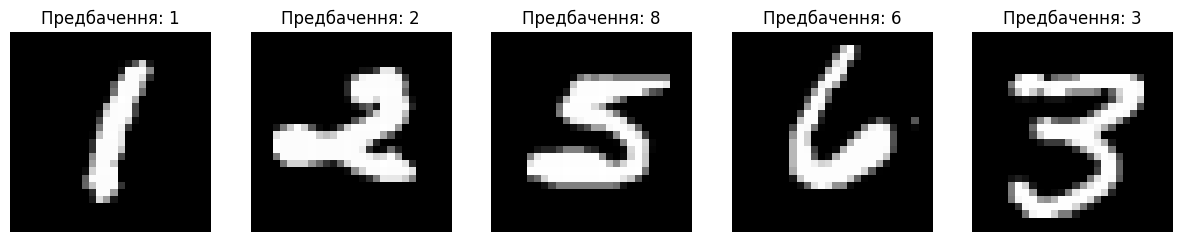

In [10]:
# Протестуйте навчену нейромережу на 10 зображеннях. З тестової вибірки візьміть 5
# випадкових зображень і передайте їх у нейронну мережу.
# Виведіть зображення та випишіть  поруч відповідь нейромережі.
# Зробіть висновок про те, чи помиляється твоя нейронна мережа, і якщо так, то як часто?

# Місце для вашого коду
# Виберемо випадкові індекси для тестових зображень
random_indices = random.sample(range(len(x_test)), 5)

# Відображення зображень та їх передбачень
plt.figure(figsize=(15, 3))
for i, idx in enumerate(random_indices):
    plt.subplot(1, 5, i + 1)
    plt.imshow(x_test[idx].reshape(28, 28), cmap='gray')
    plt.title(f"Предбачення: {tf.argmax(predictions.numpy()[idx])}")
    plt.axis('off')
plt.show()





**Висновок** : нейронна мережа здатна помилятися. Перевіривши на прикладі, видно , що не усі передбачення співпадають з картинкою.